In [15]:
import pandas as pd
import numpy as np
import ast
import json
from typing import Optional, Tuple

def get_balanced_samples(df: pd.DataFrame, 
                        n_per_class: Optional[int] = None,
                        train_fraction: float = 0.8,
                        random_state: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Randomly sample an equal number of records where hallucinated is True and False,
    split into training and test sets, and format prompts for each row.
    
    Args:
        df (pd.DataFrame): Input DataFrame with 'hallucinated', 'question', and 'options' columns
        n_per_class (int, optional): Number of samples to take from each class.
                                   If None, uses the size of the smaller class.
        train_fraction (float): Fraction of data to use for training (default: 0.8)
        random_state (int, optional): Random seed for reproducibility
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, test_df) containing balanced samples
                                         with formatted prompts
    """
    if not 0 < train_fraction < 1:
        raise ValueError("train_fraction must be between 0 and 1")
    
    # Ensure hallucinated column is boolean
    df = df.copy()

    # Filter by activation if the column exists
    if 'activation' in df.columns:
        original_len = len(df)
        df = df[df['activation'] == 0]
        filtered_len = len(df)

        if filtered_len == 0:
            raise ValueError("No rows remaining after filtering activation = 0")

    # Ensure hallucinated column is boolean
    df['hallucinated'] = df['hallucinated'].astype(bool)
    
    # Split into True and False groups
    true_samples = df[df['hallucinated'] == True]
    false_samples = df[df['hallucinated'] == False]
    
    # Get counts
    n_true = len(true_samples)
    n_false = len(false_samples)
    
    # If n_per_class not specified, use size of smaller group
    if n_per_class is None:
        n_per_class = min(n_true, n_false)
    
    # Verify we have enough samples
    if n_per_class > min(n_true, n_false):
        raise ValueError(f"Requested {n_per_class} samples per class but smallest class only has {min(n_true, n_false)} samples")
    
    # Sample from each group
    sampled_true = true_samples.sample(n=n_per_class, random_state=random_state)
    sampled_false = false_samples.sample(n=n_per_class, random_state=random_state)
    
    # Calculate number of training samples (ensuring even split between classes)
    n_train_per_class = int(n_per_class * train_fraction)
    
    # Split each class into train and test
    train_true = sampled_true.iloc[:n_train_per_class]
    test_true = sampled_true.iloc[n_train_per_class:]
    
    train_false = sampled_false.iloc[:n_train_per_class]
    test_false = sampled_false.iloc[n_train_per_class:]
    
    # Combine and shuffle train and test sets
    train_df = pd.concat([train_true, train_false])
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    test_df = pd.concat([test_true, test_false])
    test_df = test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    
    # Format prompts for both datasets
    def format_prompts(df):
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                       "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        
        formatted_df = df.copy()
        formatted_prompts = []
        
        for _, row in df.iterrows():
            question = row['question']
            
            # Parse options
            if isinstance(row['options'], str):
                options_dict = ast.literal_eval(row['options'])
            elif isinstance(row['options'], list) and len(row['options']) > 0:
                options_dict = row['options'][0]
            else:
                options_dict = row['options']
            
            # Filter out 'correct answer' from options
            options_filtered = {k: v for k, v in options_dict.items() if k != 'correct answer'}
            options_formatted = "Options: " + json.dumps(options_filtered)
            
            # Construct prompt
            prompt = f"{introduction}\n\n{question}\n\n{options_formatted}"
            formatted_prompts.append(prompt)
        
        formatted_df['prompt'] = formatted_prompts
        return formatted_df
    
    # Apply prompt formatting to both datasets
    train_df = format_prompts(train_df)
    test_df = format_prompts(test_df)
    
    print(f"Created balanced samples with {n_per_class} records per class")
    print(f"Training set: {len(train_df)} records ({n_train_per_class} per class)")
    print(f"Test set: {len(test_df)} records ({n_per_class - n_train_per_class} per class)")
    print("\nClass distribution in training set:")
    print(train_df['hallucinated'].value_counts())
    print("\nClass distribution in test set:")
    print(test_df['hallucinated'].value_counts())
    
    return train_df, test_df

In [16]:
file_path = '../data/baseline_results.tsv'

# Read the TSV file
df = pd.read_csv(file_path, sep='\t')

# Get balanced samples with train/test split
train_data, val_data = get_balanced_samples(
    df=df,
    # n_per_class=125,
    train_fraction=0.8,
    random_state=42
)


Created balanced samples with 1172 records per class
Training set: 1874 records (937 per class)
Test set: 470 records (235 per class)

Class distribution in training set:
hallucinated
False    937
True     937
Name: count, dtype: int64

Class distribution in test set:
hallucinated
True     235
False    235
Name: count, dtype: int64


In [18]:
print("total number of records:", len(df))
print("hallucinated:", df['hallucinated'].sum())
print("proportion hallucinated:",  df['hallucinated'].sum()/len(df))

total number of records: 7100
hallucinated: 1172
proportion hallucinated: 0.16507042253521126


In [19]:
df.shape, train_data.shape, val_data.shape

((7100, 9), (1874, 9), (470, 9))

In [8]:
import goodfire as gf
import os

# Get API key
api_key = os.getenv('GOODFIRE_API_KEY')
client  = gf.Client(api_key)
variant = gf.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

In [20]:
import pandas as pd 
from typing import List, Tuple


# 1. Prepare Dataset
def prepare_dataset(train_data: pd.DataFrame, hallucinated: bool=True) -> Tuple[List, pd.DataFrame]: 
  """Prepare a dataset from training data based on hallucinated or truthful examples. 
  Args:
      train_data (pd.DataFrame): DataFrame containing training data with 'hallucinated' and 'prompt' columns.
      hallucinated (bool): Boolean indicating whether to filter for hallucinated examples.
  Returns:
        tuple: A tuple containing:
            - dataset (list): A list of conversations in the required format for each example.
            - filtered_examples (pd.DataFrame): The filtered DataFrame containing only the examples 
                                                corresponding to the specified hallucinated value.
  """
  filtered_examples = train_data[train_data['hallucinated'] == hallucinated]
  dataset = [
    [
      {"role": "user", "content": prompt},
      {"role": "assistant", "content": "3"} 
    ] for prompt in filtered_examples["prompt"].tolist()
  ]
  return dataset, filtered_examples


# 2. Chunk Dataset
def chunk_dataset(dataset, chunk_size=64): 
  """
    Split a dataset into smaller chunks for API processing.
    Args:
        dataset: The dataset to chunk.
        chunk_size: Maximum size of each chunk.
    Yields:
        Chunks of the dataset.
    """
  for i in range(0, len(dataset), chunk_size):
    yield dataset[i:i+chunk_size]
    

# 3. Contrast Features
def contrast_features(client, variant, dataset_1_chunks, dataset_2_chunks, top_k=50):
  """
    Perform feature contrast for two datasets using Goodfire.
    Args:
        client: The Goodfire client instance.
        variant: The model variant to use.
        dataset_1_chunks: List of dataset chunks for the first class.
        dataset_2_chunks: List of dataset chunks for the second class.
        top_k: Number of top features to extract.
    Returns:
        A tuple of feature groups for dataset_1 and dataset_2.
    """ 
  hallucinated_features = None  # Initialize to None
  truthful_features = None 
  
  for d1_chunk, d2_chunk in zip(dataset_1_chunks, dataset_2_chunks):
    hallucinated_chunk_features, truthful_chunk_features = client.features.contrast(
      dataset_1=d1_chunk, 
      dataset_2=d2_chunk, 
      model=variant, 
      top_k=top_k
    )
    if hallucinated_features is None:
        hallucinated_features = hallucinated_chunk_features
    else:
        hallucinated_features = hallucinated_features.union(hallucinated_chunk_features)

    if truthful_features is None:
        truthful_features = truthful_chunk_features
    else:
        truthful_features = truthful_features.union(truthful_chunk_features)

  return hallucinated_features, truthful_features
  


# 4. Rerank Features
def rerank_features(client, features, query, model, top_k=50):
  """
  Rerank features based on a query.
  Args:
      client: The Goodfire client instance.
      features: The features to rerank.
      query: Query string for reranking.
      model: The model variant to use.
      top_k: Number of top features to return.
  Returns:
      Reranked features.
  """
  return client.features.rerank(
    features=features,
    query=query,
    model=model,
    top_k=top_k
  )
  
  
# 5. Combine Features 
def combine_features(hallucinated_features, truthful_features):
  """
  Combine two sets of features into a single set.
  Args:
      hallucinated_features: Features from the hallucinated dataset.
      truthful_features: Features from the truthful dataset.
  Returns:
      A combined set of features.
  """
  return hallucinated_features | truthful_features

In [21]:
# Step 1: Prepare datasets
dataset_1, hallucinated_examples = prepare_dataset(train_data, hallucinated=True)
dataset_2, truthful_examples = prepare_dataset(train_data, hallucinated=False)

# Step 2: Chunk datasets
chunk_size = 64
dataset_1_chunks = list(chunk_dataset(dataset_1, chunk_size))
dataset_2_chunks = list(chunk_dataset(dataset_2, chunk_size))

# Step 3: Contrast features
hallucinated_features, truthful_features = contrast_features(
    client,
    variant,
    dataset_1_chunks,
    dataset_2_chunks,
    top_k=50
)
# query1_ = "medical response hallucinated",
# Step 4: Rerank features
hallucinated_features = rerank_features(
    client,
    hallucinated_features,
    query="unknown medical query",
    model=variant,
    top_k=25
)

truthful_features = rerank_features(
    client,
    truthful_features,
    query="medical query",
    model=variant,
    top_k=25
)

# Step 5: Combine features
features_to_look_at = combine_features(hallucinated_features, truthful_features)

# Final Output
print(features_to_look_at)

FeatureGroup([
   0: "Medical report negation of concerning findings",
   1: "Normal or unremarkable findings in medical reports",
   2: "Medical history sections and references in clinical documentation",
   3: "Chronic medical conditions with complex or contested etiologies",
   4: "Medical comorbidities and condition combinations",
   5: "Medical symptom descriptions using tentative language",
   6: "Medical diagnostic procedures and test ordering sequences",
   7: "Medical history documentation patterns in clinical settings",
   8: "Vital signs measurements in medical documentation",
   ...
   49: "Medical descriptions of skin conditions and dermatological issues"
])


In [30]:
from itertools import combinations


class FeatureSearch:
    """A class for systematically searching through 
      combinations of features to evaluate their predictive power.
    """

    def __init__(self, feature_group):
        self.feature_group = feature_group

    def grid(self, k_features_per_combo: int = 2):
        """Perform a grid search over all possible combinations of features.
        Args:
            k_features_per_combo (int): The number of features to include in each combination.
        Returns:
            list: All possible k-sized combinations of features from the feature group.
        """

        # Get all possible combinations of features
        return list(combinations(self.feature_group, k_features_per_combo))

In [31]:
async_client = gf.AsyncClient(api_key=api_key, base_url="https://api.goodfire.ai")

In [11]:
import pandas as pd
import asyncio
from tqdm.asyncio import tqdm_asyncio


MIN_SAMPLES_PER_CLASS = min(
    len(hallucinated_examples),
    len(truthful_examples),
)

async def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: gf.FeatureGroup,
    k=50,
    batch_size=50
):
    if k < len(features_to_use_for_classification):
        raise ValueError(
            "k must be greater than the number of features to use for classification"
        )

    samples = []
    all_samples = sample_class[0:MIN_SAMPLES_PER_CLASS]

    # Process in batches
    for i in range(0, len(all_samples), batch_size):
        batch = all_samples[i:i + batch_size]
        tasks = []

        for idx, row in batch.iterrows():
            prompt = row["prompt"]
            tasks.append(
                async_client.features.inspect(
                    [
                        {"role": "user", "content": f"{prompt}"},
                        {"role": "assistant", "content": "3"}
                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )
            )

        # Process this batch
        batch_results = await tqdm_asyncio.gather(*tasks)
        for context in batch_results:
            features = context.top(k=k)
            samples.append(features)

    return samples

async def process_all_classes():
    print("Computing truthful features...")
    truthful_class_features = await _get_feature_acts_for_sample_class(
        truthful_examples, features_to_look_at, k=50
    )

    print("Computing hallucinated features...")
    hallucinated_class_features = await _get_feature_acts_for_sample_class(
        hallucinated_examples, features_to_look_at, k=50
    )


    return truthful_class_features, hallucinated_class_features

truthful_class_features, hallucinated_class_features = await process_all_classes()

NameError: name 'hallucinated_examples' is not defined

In [29]:
import pandas as pd
import asyncio
from tqdm.asyncio import tqdm_asyncio
import httpx

MIN_SAMPLES_PER_CLASS = min(
    len(hallucinated_examples),
    len(truthful_examples),
)

async def inspect_with_retry(client, prompt, model, features, retries=3, delay=2):
    """
    Inspect features with retry logic.
    
    Args:
        client: The async client instance.
        prompt: The prompt to send to the model.
        model: The model to use.
        features: The feature group to inspect.
        retries: Maximum number of retries.
        delay: Delay between retries in seconds.
    
    Returns:
        The response from the inspect call.
    """
    for attempt in range(retries):
        try:
            return await client.features.inspect(
                [
                    {"role": "user", "content": f"{prompt}"},
                    {"role": "assistant", "content": "3"}
                ],
                model=model,
                features=features,
            )
        except (httpx.ConnectError, httpx.ReadTimeout) as e:
            print(f"Retry {attempt + 1}/{retries} for prompt '{prompt}' failed with error: {e}")
            if attempt < retries - 1:
                await asyncio.sleep(delay)
            else:
                raise

async def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: gf.FeatureGroup,
    k=50,
    batch_size=100,
    retries=3,
    delay=2
):
    if k < len(features_to_use_for_classification):
        raise ValueError(
            "k must be greater than the number of features to use for classification"
        )

    samples = []
    all_samples = sample_class[0:MIN_SAMPLES_PER_CLASS]

    # Process in batches
    for i in range(0, len(all_samples), batch_size):
        batch = all_samples[i:i + batch_size]
        tasks = []

        for idx, row in batch.iterrows():
            prompt = row["prompt"]
            tasks.append(
                inspect_with_retry(
                    async_client,
                    prompt,
                    model=variant,
                    features=features_to_use_for_classification,
                    retries=retries,
                    delay=delay
                )
            )

        # Process this batch
        batch_results = await tqdm_asyncio.gather(*tasks, desc=f"Processing batch {i // batch_size + 1}")
        for context in batch_results:
            features = context.top(k=k)
            samples.append(features)

    return samples

async def process_all_classes():
    print("Computing truthful features...")
    truthful_class_features = await _get_feature_acts_for_sample_class(
        truthful_examples, features_to_look_at, k=50
    )

    print("Computing hallucinated features...")
    hallucinated_class_features = await _get_feature_acts_for_sample_class(
        hallucinated_examples, features_to_look_at, k=50
    )

    return truthful_class_features, hallucinated_class_features

# Run the processing
truthful_class_features, hallucinated_class_features = await process_all_classes()

Computing truthful features...


Processing batch 10: 100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


Computing hallucinated features...


Processing batch 6: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Retry 1/3 for prompt 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

To examine the vaginal cells in of the rape victim test used is -

Options: {"0": "Lugol's iodine test", "1": "Takayama test", "2": "Florence test", "3": "Precipitin test"}' failed with error: [Errno 8] nodename nor servname provided, or not known


Processing batch 10: 100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


In [30]:
len(hallucinated_examples), len(truthful_examples)

(937, 937)

In [31]:
len(truthful_class_features[0]), len(hallucinated_class_features[0])

(50, 50)

In [32]:
import pickle

# Save the data to a file
def save_feature_activations(name: str, feature_activations):
  with open(f"../data/{name}.pkl", "wb") as f:
      pickle.dump(feature_activations, f)


save_feature_activations("truthful_class_features", truthful_class_features)
save_feature_activations("hallucinated_class_features", hallucinated_class_features)

In [32]:
import pickle
# Load the data from a file
def load_feature_activations(name: str):
  with open(f"../data/{name}.pkl", "rb") as f:
      activations = pickle.load(f)
  return activations

truthful_class_features = load_feature_activations('truthful_class_features')
hallucinated_class_features = load_feature_activations('hallucinated_class_features')

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


# Grid search may take a while, you can curate the feature list to speed this process up significantly

def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(
    x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = DecisionTreeClassifier(
    max_depth=depth,
    min_samples_leaf=len(train_x) // 10,
    random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score,

In [34]:
def find_best_combo(features, k_features_per_combo=2):
    combos = FeatureSearch(features).grid(k_features_per_combo=k_features_per_combo)
    best_combo = None
    best_model = None
    mean_act_negative = 0
    mean_act_positive = 0
    support_vector_distances = 0
    best_score = 0

    for combo in tqdm.tqdm(combos):
        # Create a linear regression model
        def _select_feature_acts(combo, row):
            output = []
            for index, feature in enumerate(combo):
                for feature_act in row:
                    if feature_act.feature.uuid == feature.uuid:
                        output.append(feature_act.activation)
                        break

            return output

        x_hallucinated = [
            _select_feature_acts(combo, row) for row in hallucinated_class_features
        ]
        x_truthful = [
            _select_feature_acts(combo, row) for row in truthful_class_features
        ]

        y_hallucinated = [-1] * len(x_hallucinated)
        y_truthful = [1] * len(x_truthful)

        x = x_hallucinated + x_truthful
        y = y_truthful + y_hallucinated

        model, pred, score = train_tree(x, y, depth=len(combo))

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    return best_combo, best_score, best_model

In [35]:
best_combo_at_k = {}

for i in range(4):
    best_combo, best_score, best_model = find_best_combo(
      features_to_look_at, k_features_per_combo = i + 1
      )
    print(i + 1, best_combo, best_score, best_model)
    best_combo_at_k[i + 1] = (best_combo, best_score, best_model)

100%|██████████| 50/50 [00:00<00:00, 119.46it/s]


1 (Feature("Medical history documentation patterns in clinical settings"),) 0.642965204236006 DecisionTreeClassifier(max_depth=1, min_samples_leaf=93, random_state=42)


100%|██████████| 1225/1225 [00:15<00:00, 80.20it/s]


2 (Feature("Medical history documentation patterns in clinical settings"), Feature("Vital signs measurements in medical documentation")) 0.642965204236006 DecisionTreeClassifier(max_depth=2, min_samples_leaf=93, random_state=42)


  9%|▉         | 1825/19600 [00:31<05:08, 57.67it/s]


KeyboardInterrupt: 

In [38]:
for k in [1, 2, 3]:
    combo, score, model = best_combo_at_k[k]
    print(f"k={k} features: score={score}")
    
best_individual_feature = best_combo_at_k[3][0][0]
best_individual_feature

k=1 features: score=0.642965204236006
k=2 features: score=0.642965204236006
k=3 features: score=0.642965204236006


Feature("Medical history documentation patterns in clinical settings")

In [39]:
feature_grp = client.features.neighbors(best_individual_feature, model="meta-llama/Meta-Llama-3.1-8B-Instruct" )
feature_grp

FeatureGroup([
   0: "Section headers and structural elements in medical records and forms, especially patient history and allergies",
   1: "Medical history sections and references in clinical documentation",
   2: "Medical warnings about pre-existing conditions and health status",
   3: "Medical comorbidities and condition combinations",
   4: "References to people who have experienced trauma or hardship",
   5: "The AI explaining it cannot remember past conversations",
   6: "Descriptions of someone's qualifications and professional background in evaluative contexts",
   7: "Patient history and symptom description in clinical documentation",
   8: "Offensive request from the user",
   9: "Phrases establishing credibility through accumulated experience"
])

In [40]:
# Anyways let's look at the best overall tree

BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

best_features, best_tree

((Feature("Medical history documentation patterns in clinical settings"),
  Feature("Vital signs measurements in medical documentation"),
  Feature("Inappropriate content focusing on bathroom urgency and loss of control")),
 DecisionTreeClassifier(max_depth=3, min_samples_leaf=93, random_state=42))

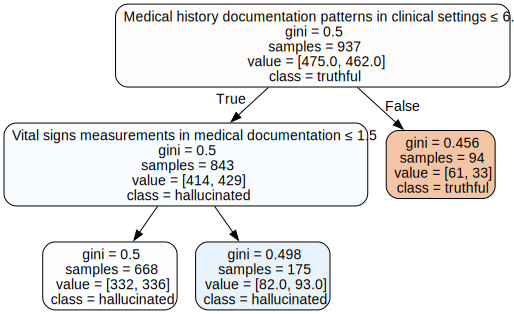

In [42]:
# Let's visualize the tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
  best_tree, 
  out_file=None, 
  feature_names=[feature.label for feature in best_features], 
  class_names=['truthful', 'hallucinated'], 
  filled=True, 
  rounded=True, 
  special_characters=True
  )
graph = graphviz.Source(dot_data)
graph

In [44]:
import asyncio
import tqdm
from concurrent.futures import ThreadPoolExecutor

def run_in_thread(func, *args, **kwargs):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    # Call the function directly if it's not async
    result = func(*args, **kwargs)

    loop.close()
    return result

def get_feature_activations(client, variant, examples, features, k=50):
    """
    Get feature activations for a set of examples using Goodfire with run_in_thread
    """
    samples = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures_list = []

        for example in examples:
            futures_list.append(
                executor.submit(
                    run_in_thread,
                    client.features.inspect,  # Async function
                    example,
                    model=variant,
                    features=features,
                )
            )

        for future in tqdm.tqdm(futures_list, desc="Fetching Features"):
            context = future.result()
            features = context.top(k=k)
            samples.append(features)

    return samples

In [45]:
dataset_1[0:1]

[[{'role': 'user',
   'content': 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].\n\nRapid tooth separation works on following principle:\n\nOptions: {"0": "Wedge principle.", "1": "Traction principle.", "2": "Both of the above.", "3": "None."}'},
  {'role': 'assistant', 'content': '3'}]]

In [46]:
example_activations = get_feature_activations(client, variant, dataset_1[0:1], best_features)
example_activations

Fetching Features: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


[FeatureActivations(
    0: (Feature("Vital signs measurements in medical documentation"), 1)
    1: (Feature("Medical history documentation patterns in clinical settings"), 0)
    2: (Feature("Inappropriate content focusing on bathroom urgency and loss of control"), 0)
    3: (Feature("Variable assignments and value retrievals in calculator code"), 0)
    4: (Feature("Birth dates in biographical/historical contexts"), 0)
    5: (Feature("Syntactical elements in programming code and database queries"), 0)
    6: (Feature("Discussion of limited or scarce resources and constraints"), 0)
    7: (Feature("Syntactical special characters and delimiters in programming contexts"), 0)
    8: (Feature("feature_0"), 0)
    9: (Feature("The Russian word состав (composition/compilation) and its variations"), 0)
    ...
    22: (Feature("Technical documentation describing widespread applications and uses"), 0)
 )]

In [1]:
import pickle
import goodfire as gf
from typing import List, Dict, Tuple, Any
import numpy as np

class HallucinationClassifier:
    def __init__(self, model_path: str, api_key: str):
        """
        Initialize the hallucination classifier with a saved model and features.
        
        Args:
            model_path: Path to the saved pickle file containing both the model and features
            api_key: Goodfire API key for accessing the service
        """
        # Load the model and features
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
            self.model = model_data['model']
            self.features = model_data['features']
        self.client = gf.Client(api_key)
        self.variant = gf.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

    def _format_prompt(self, question: str) -> List[Dict[str, str]]:
        """Format a question into the expected prompt structure."""
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                      "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        return [{"role": "user", "content": f"{introduction}\n\n{question}"}]
      

    def _get_feature_activations(self, prompt: List[Dict[str, str]]) -> List[float]:
        """Get feature activations for the input prompt."""
        context = self.client.features.inspect(
            messages=prompt,
            model=self.variant,
            features=self.features
        )
        
        # Get activations for our specific features
        activations = []
        features_dict = {f.uuid: 0.0 for f in self.features}
        
        for feature_act in context.top(k=len(self.features)):
            if feature_act.feature.uuid in features_dict:
                features_dict[feature_act.feature.uuid] = feature_act.activation
        
        # Maintain order matching the original features
        for feature in self.features:
            activations.append(features_dict[feature.uuid])
            
        return activations

    def predict(self, question: str, debug: bool = False) -> Tuple[int, float]:
        """
        Predict whether a given question-answer pair is likely to contain hallucination.
        
        Args:
            question: The question text
            debug: If True, print debugging information about feature activations
            
        Returns:
            Tuple containing:
            - Prediction (0 for truthful, 1 for hallucinated)
            - Confidence score (probability of the predicted class)
        """
        # Format the prompt
        prompt = self._format_prompt(question)
        
        # Get feature activations
        activations = self._get_feature_activations(prompt)
        
        if debug:
            print("\nFeature Activations:")
            for feature, activation in zip(self.features, activations):
                print(f"{feature.label}: {activation:.4f}")
            
            # Get the decision path
            decision_path = self.model.decision_path([activations])
            feature_importance = self.model.feature_importances_
            
            print("\nFeature Importance in Model:")
            for feature, importance in zip(self.features, feature_importance):
                print(f"{feature.label}: {importance:.4f}")
            
            print("\nDecision Path:")
            node_indicator = decision_path[0]
            leaf_id = self.model.apply([activations])[0]
            
            # Get thresholds and feature indices for each node in path
            for node_id in node_indicator.indices:
                if node_id != leaf_id:
                    feature_idx = self.model.tree_.feature[node_id]
                    threshold = self.model.tree_.threshold[node_id]
                    feature_name = self.features[feature_idx].label
                    feature_value = activations[feature_idx]
                    print(f"Node {node_id}: {feature_name} = {feature_value:.4f} {'<=' if feature_value <= threshold else '>'} {threshold:.4f}")
        
        # Make prediction
        prediction = self.model.predict([activations])[0]
        probabilities = self.model.predict_proba([activations])[0]
        confidence = probabilities[prediction]
        
        if debug:
            print(f"\nProbabilities:")
            print(f"Truthful: {probabilities[0]:.4f}")
            print(f"Hallucinated: {probabilities[1]:.4f}")
        
        return int(prediction), float(confidence)


In [2]:
def save_model_and_features(model, features, output_path: str):
    """Save both the sklearn decision tree model and Goodfire features to a file.
    
    Args:
        model: The trained sklearn decision tree model
        features: The Goodfire features used by the model
        output_path: Path where to save the pickle file
    """
    model_data = {
        'model': model,
        'features': features
    }
    with open(output_path, 'wb') as f:
        pickle.dump(model_data, f)

In [ ]:
# Save the model and best_features

model_path = "hallucination_model.pkl"
save_model_and_features(best_tree, best_features, model_path)



In [6]:
def load_model(model_path):
  with open(model_path, 'rb') as f:
   return pickle.load(f) 
  
model = load_model(model_path=model_path)  

In [9]:
# Initialize the classifier (now simpler, no need to pass features separately)
classifier = HallucinationClassifier(
    model_path=model_path,
    api_key=api_key
)


In [22]:
# Make predictions - Example from truthful dataframe

prompt_example = truthful_examples.iloc[20]['prompt']
print(prompt_example)

prediction, confidence = classifier.predict(prompt_example,debug=True)
print("Prediction: ", prediction)
print(f"Prediction: {'Hallucinated' if prediction == 1 else 'Truthful'}")
print(f"Confidence: {confidence:.2f}")

You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

A karyotype 45, XX, rob (14; 21) (q10; q10) can correspond to a woman:

Options: {"0": "With Down syndrome with a Robertsonian translocation.", "1": "Sana, carrier of a Robertsonian translocation.", "2": "With Prader-Willi syndrome.", "3": "With Edwards syndrome."}

Feature Activations:
Medical history documentation patterns in clinical settings: 0.0000
Vital signs measurements in medical documentation: 0.0000
Inappropriate content focusing on bathroom urgency and loss of control: 0.0000

Feature Importance in Model:
Medical history documentation patterns in clinical settings: 0.9495
Vital signs measurements in medical documentation: 0.0505
Inappropriate content focusing on bathroom urgency and loss of control: 0.0000

Decision Path:
Node 0: Medical history documentation patterns in clinical settings = 0.0000 <= 6.5000
Node 1: Vital signs m

## EVALUATION ON TRAIN & TEST DATASETS

In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def evaluate_model_predictions(classifier, truthful_examples, hallucinated_examples):
    """
    Evaluate model predictions across all examples.
    
    Args:
        classifier: The HallucinationClassifier instance
        truthful_examples: DataFrame containing truthful examples
        hallucinated_examples: DataFrame containing hallucinated examples
    """
    # Store results
    results = []
    
    # Process truthful examples
    print("\nProcessing truthful examples...")
    for idx, row in tqdm(truthful_examples.iterrows(), total=len(truthful_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'truthful',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Process hallucinated examples
    print("\nProcessing hallucinated examples...")
    for idx, row in tqdm(hallucinated_examples.iterrows(), total=len(hallucinated_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'hallucinated',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Calculate overall statistics
    total_predictions = len(results_df)
    print("\nOverall Statistics:")
    print(f"Total examples evaluated: {total_predictions}")
    
    # Prediction distribution
    pred_dist = results_df['predicted'].value_counts()
    print("\nPrediction Distribution:")
    for pred, count in pred_dist.items():
        percentage = (count/total_predictions) * 100
        print(f"{pred}: {count} ({percentage:.1f}%)")
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    confusion = pd.crosstab(results_df['true_label'], results_df['predicted'])
    print(confusion)
    
    # Calculate metrics by class
    print("\nMetrics by True Label:")
    for label in ['truthful', 'hallucinated']:
        class_results = results_df[results_df['true_label'] == label]
        correct = (class_results['true_label'] == class_results['predicted']).sum()
        total = len(class_results)
        accuracy = (correct/total) * 100
        avg_confidence = class_results['confidence'].mean()
        
        print(f"\n{label.title()} Examples:")
        print(f"Accuracy: {accuracy:.1f}%")
        print(f"Average Confidence: {avg_confidence:.3f}")
    
    # Return the results DataFrame for further analysis if needed
    return results_df


### TRAIN DATASET EVALUATION

In [24]:
_, hallucinated_examples_test = prepare_dataset(val_data, hallucinated=True)
_, truthful_examples_test = prepare_dataset(val_data, hallucinated=False)

In [25]:
## TRAINING DATASET EVALUATION

# Assuming classifier is already initialized
results_df = evaluate_model_predictions(classifier, truthful_examples_test, hallucinated_examples_test)

# You can do additional analysis on results_df if needed
# For example, look at high confidence mistakes:
high_conf_mistakes = results_df[
    (results_df['true_label'] != results_df['predicted']) & 
    (results_df['confidence'] > 0.8)
]


Processing truthful examples...


100%|██████████| 235/235 [09:25<00:00,  2.40s/it]



Processing hallucinated examples...


100%|██████████| 235/235 [09:04<00:00,  2.32s/it]


Overall Statistics:
Total examples evaluated: 470

Prediction Distribution:
hallucinated: 414 (88.1%)
truthful: 56 (11.9%)

Confusion Matrix:
predicted     hallucinated  truthful
true_label                          
hallucinated           209        26
truthful               205        30

Metrics by True Label:

Truthful Examples:
Accuracy: 12.8%
Average Confidence: 0.489

Hallucinated Examples:
Accuracy: 88.9%
Average Confidence: 0.490


In [26]:
high_conf_mistakes

,true_label,predicted,confidence


### Train Performance Interpretation

The recall of 86% is quite good - the model catches 86% of all hallucinations. This aligns with your goal of preventing medical hallucinations, as it misses relatively few of them.
The precision of 59.7% means that when the model flags something as a hallucination, it's right about 60% of the time. The relatively lower precision indicates that the model is somewhat aggressive in flagging content as hallucinated.
This trade-off (high recall, moderate precision) might be acceptable for the medical use case, as:

In medical contexts, missing a hallucination (false negative) could be more dangerous than incorrectly flagging truthful content (false positive)
False positives can be manually reviewed, while missed hallucinations might go unnoticed

### TEST DATASET EVALUATION